In [1]:
import pysnnblaze as pb
import numpy as np
import os

os.environ["CC"] = "gcc"
os.environ["CXX"] = "g++"

In [2]:
tau_m = 10e-3       # membrane time constant
C_m = 1             # membrane capacitance - unitary for simplicity
v_rest = -70e-3     # resting potential
v_reset = -70e-3    # reset potential after spike
v_thresh = -50e-3   # threshold
refractory = 5e-3   # refractory period

neuron = pb.LIFNeuron(tau_m=tau_m, C_m=C_m, v_rest=v_rest, v_reset=v_reset, v_thresh=v_thresh, refractory=refractory)

## Testing a LIF Neuron
Remark that the neuron objects contain functions that manipulates an array representing the neuron states (membrane potentials in this case). However, it does not contain the state itself. 

In [3]:
# Testing a LIF Neuron

# Network state variables
state_arr = np.array([0], dtype=np.float64)
last_spike_arr = np.array([0], dtype=np.float64)
last_update_arr = np.array([0], dtype=np.float64)

print(f'State at start: {state_arr}')
print(f'Last spike time at start: {last_spike_arr}')

# Neurons receives a spike of weight 1 at time 0
neuron.update(0., state_arr, last_spike_arr, last_update_arr, 0.9)
print(f'State after receiving spike: {state_arr}')
print(f'Last spike time after receiving spike: {last_spike_arr}')

# Update neuron state after 1 time unit
neuron.update(1, state_arr, last_spike_arr, last_update_arr, 0.)
print(f'State after 1 time unit: {state_arr}')
print(f'Last spike time after 1 time unit: {last_spike_arr}')

# Update neuron state to surpass threshold
neuron.update(2, state_arr, last_spike_arr, last_update_arr, 100)
print(f'State after surpassing threshold: {state_arr}')
print(f'Last spike time after surpassing threshold: {last_spike_arr}')

State at start: [0.]
Last spike time at start: [0.]
State after receiving spike: [0.]
Last spike time after receiving spike: [0.]
State after 1 time unit: [-0.07]
Last spike time after 1 time unit: [0.]
State after surpassing threshold: [-0.07]
Last spike time after surpassing threshold: [2.]


## Testing the state monitor

In [4]:
monitor = pb.SpikeMonitor()
monitor.on_spike(0, 2)
monitor.on_spike(1, 4)
monitor.on_spike(2, 5)
monitor.spike_list

[(0.0, 2), (1.0, 4), (2.0, 5)]

## Testing a Neural Network

In [5]:
nn = pb.NeuralNetwork()
nn.set_spike_monitor(monitor)
nn.add_neuron_population(5, neuron)
monitor.reset_spikes()

# Spikes events with no synapses
nn.schedule_spike_event(0, 0, 100.)
nn.schedule_spike_event(2.2, 4, 100.)
nn.run(5.0)
print(f'Observed spike events (time, neuron id): {monitor.spike_list}')

Observed spike events (time, neuron id): [(0.0, 0), (2.2, 4)]


In [6]:
# Same experiment with 2 synapses 
nn = pb.NeuralNetwork()
nn.set_spike_monitor(monitor)
nn.add_neuron_population(5, neuron)
monitor.reset_spikes()

syn1 = pb.Synapse(0, 1, 100.0, 1.0)
syn2 = pb.Synapse(4, 2, 100.0, 1.0)

nn.add_synapse(syn1)
nn.add_synapse(syn2)

nn.schedule_spike_event(0.1, 0, 100.0)
nn.schedule_spike_event(2.2, 4, 100.0)

nn.run(10)
print(f'Observed spike events (time, neuron id): {monitor.spike_list}')

Observed spike events (time, neuron id): [(0.1, 0), (1.1, 1), (2.2, 4), (3.2, 2)]


## Random neural network simulation

In [7]:
import random

# Neuron parameters
tau_m = 20e-3       # membrane time constant [s]
C_m = 200e-12       # membrane capacitance [F]
v_rest = -70e-3     # resting potential [V]
v_reset = -70e-3    # reset potential after spike [V]
v_thresh = -50e-3   # threshold [V]
refractory = 5e-3   # refractory period [s]

neuron = pb.LIFNeuron(tau_m=tau_m, C_m=C_m, v_rest=v_rest, v_reset=v_reset, v_thresh=v_thresh, refractory=refractory)

# Network parameters
num_neurons = 100
connection_prob = 0.2
weight_range_exc = (1.5e-12, 1.5e-12)  # Weight range for excitatory neurons
weight_range_inh = (-2e-12, -2e-12)  # Weight range for inhibitory neurons
delay_range = (0.001, 0.002)
inhibitory_ratio = 0.2
num_inhibitory = int(num_neurons * inhibitory_ratio)

# Generate the Erdős–Rényi random graph with random weights and delays
graph = []
for pre in range(num_neurons):
    for post in range(num_neurons):
        if pre != post:
            if random.random() < connection_prob:
                # Determine if the presynaptic neuron is inhibitory
                if pre >= num_neurons - num_inhibitory:
                    weight = random.uniform(*weight_range_inh)
                else:
                    weight = random.uniform(*weight_range_exc)
                delay = random.uniform(*delay_range)
                graph.append((pre, post, weight, delay))

# Generate spike events for all neurons and store them in a middle storage
# Parameters
spike_rate = 40.0  # spikes per second per neuron
t_start = 0.0
t_end = 5.0
input_neurons = 10
spike_storage = []
for neuron_id in range(input_neurons):
    t = t_start
    while t < t_end:
        # Inter-spike interval sampled from exponential distribution
        isi = random.expovariate(spike_rate)  # mean interval = 1 / spike_rate
        t += isi
        if t < t_end:
            magnitude = 30.0*C_m  # spike magnitude
            spike_storage.append((t, neuron_id, magnitude))

In [8]:
# Initialize network and monitor
nn = pb.NeuralNetwork()
nn.set_spike_monitor(monitor)
state_monitor = pb.StateMonitor(100e-6)
nn.set_state_monitor(state_monitor)
nn.add_neuron_population(num_neurons, neuron)
monitor.reset_spikes()

# Instantiate the graph into the neural network
for pre, post, weight, delay in graph:
    syn = pb.Synapse(pre, post, weight, delay)
    nn.add_synapse(syn)

# Add the stored spike events to the schedule
for t, neuron_id, magnitude in spike_storage:
    nn.schedule_spike_event(t, neuron_id, magnitude)

# Run simulation
nn.run(.1)

# Output observed spikes
print(f'Number of events: {len(monitor.spike_list)}')
print(f'Observed spike events (time, neuron id): {monitor.spike_list}')

Number of events: 1247
Observed spike events (time, neuron id): [(0.006559700906715327, 9), (0.008359725957652568, 1), (0.00863221298735319, 6), (0.01187662372654839, 0), (0.013128079092200888, 9), (0.013176133669637501, 7), (0.013389664647666406, 1), (0.014433595311058867, 5), (0.014479017205858083, 80), (0.014605340962603016, 93), (0.014622441153522903, 4), (0.014720391507887398, 94), (0.014728095754938213, 78), (0.014733970446539242, 83), (0.014739798365446486, 76), (0.014775497714316592, 13), (0.0147814941309734, 44), (0.014797999439016888, 65), (0.014892027574700371, 45), (0.014901597342376522, 56), (0.014941194049130998, 96), (0.015006027398413738, 40), (0.015011388329321482, 72), (0.01507184694477825, 87), (0.01529479015227851, 60), (0.015539379242352092, 36), (0.015711005528110472, 53), (0.015812709162300112, 66), (0.015840370107391248, 28), (0.01586701426349655, 23), (0.015883520485173063, 79), (0.0159102805636001, 71), (0.01591061284084789, 55), (0.016063774248451138, 25), (0

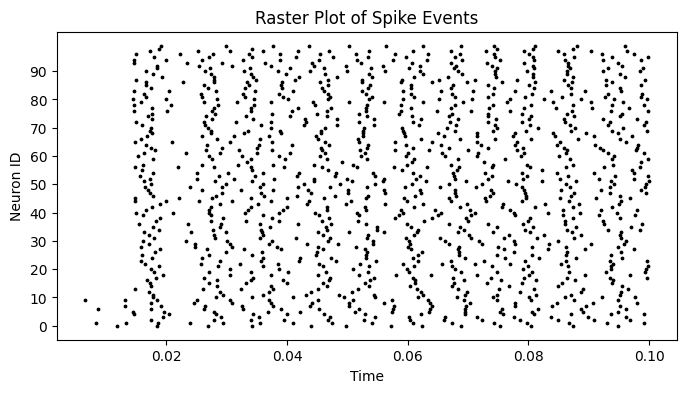

In [9]:
import matplotlib.pyplot as plt

# Plotting spike events
spike_times = [t for t, n in monitor.spike_list]
neuron_ids = [n for t, n in monitor.spike_list]

plt.figure(figsize=(8, 4))
plt.scatter(spike_times, neuron_ids, c='black', marker='o', s=3)
plt.xlabel('Time')
plt.ylabel('Neuron ID')
plt.title('Raster Plot of Spike Events')
plt.yticks(range(0, num_neurons, num_neurons//10))  # Show every 10th neuron ID
plt.show()

/tmp/ipykernel_467515/1890621876.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(spike_times, neuron_ids, '.k', markersize=2, label='Spikes', c='orange')


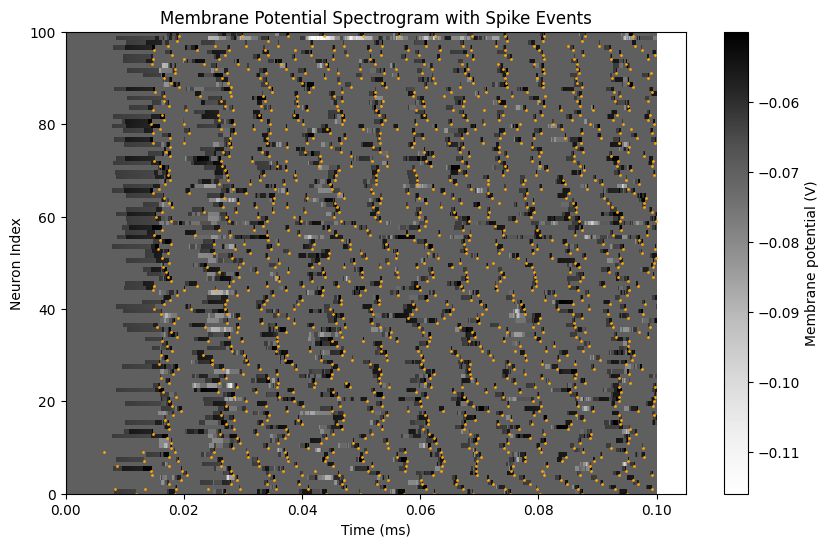

In [10]:
times = np.array([t for t, _ in state_monitor.state_vector_list])
states = np.array([vec for _, vec in state_monitor.state_vector_list])  # shape: (num_time_points, num_neurons)

# Transpose so neurons are on y-axis
states = states.T  # shape: (num_neurons, num_time_points)
num_neurons = states.shape[0]

plt.figure(figsize=(10, 6))
plt.imshow(states, aspect='auto', cmap='Greys', origin='lower',
           extent=[times[0], times[-1], 0, num_neurons], interpolation='none')

# Overlay spike events
spike_times = [t for t, n in monitor.spike_list]
neuron_ids = [n for t, n in monitor.spike_list]
plt.plot(spike_times, neuron_ids, '.k', markersize=2, label='Spikes', c='orange')

plt.colorbar(label='Membrane potential (V)')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title('Membrane Potential Spectrogram with Spike Events')
plt.show()

## Comparison to Brian 2

Number of spike events: 1306


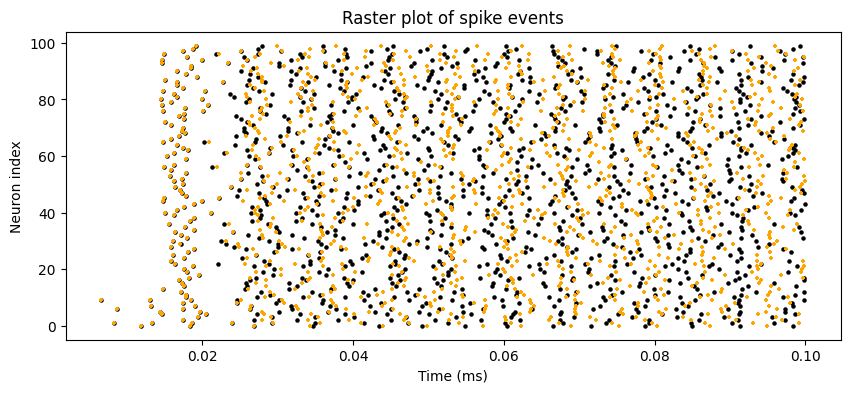

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

# ==============================
# Parameters
# ==============================
tau_m = 20*ms
C = 200*pF
v_rest = -70*mV
v_reset = -70*mV
v_thresh = -50*mV
refractory_period = 5*ms

defaultclock.dt = 1*us

eqs = '''
dv/dt = (v_rest - v) / tau_m : volt (unless refractory)
'''
G = NeuronGroup(
    num_neurons,
    eqs,
    threshold='v>v_thresh',
    reset='v=v_reset',
    refractory=refractory_period,
    method='exact'
)
G.v = v_rest

S = Synapses(G, G, 'w : volt', on_pre='v_post += w')

for pre, post, weight, delay in graph:
    S.connect(i=pre, j=post)
    S.w[pre, post] = (weight/C_m)*volt
    S.delay[pre, post] = delay*second

# Convert spike_storage → arrays
indices = np.array([neuron_id for _, neuron_id, _ in spike_storage])
times = np.array([t for t, _, _ in spike_storage]) * second

# Align times to simulation clock resolution
dt = defaultclock.dt
times = np.round(times / dt) * dt

# Remove duplicates (neuron, time) that would cause errors
pairs = set()
clean_indices, clean_times = [], []
for idx, t in zip(indices, times):
    if (idx, float(t)) not in pairs:
        pairs.add((idx, float(t)))
        clean_indices.append(idx)
        clean_times.append(t)

P = SpikeGeneratorGroup(input_neurons, indices=clean_indices, times=clean_times)
SP = Synapses(P, G, on_pre='v_post += 30*mV')  # input strength
SP.connect(i=np.arange(input_neurons), j=np.arange(input_neurons))

spikemon = SpikeMonitor(G)
statemon = StateMonitor(G, 'v', record=True)  # record neuron 0 as example

run(0.1*second)

print(f"Number of spike events: {spikemon.num_spikes}")

# Raster plot
plt.figure(figsize=(10,4))
plt.scatter(spikemon.t/second, spikemon.i, s=5, c='black')
plt.scatter(spike_times, neuron_ids, c='orange', s=5, marker='+')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Raster plot of spike events')
plt.show()

WARNING    /tmp/ipykernel_467515/2179699531.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(spikemon.t / ms, spikemon.i, '.k', markersize=2, label='Spikes', c='orange')
 [py.warnings]


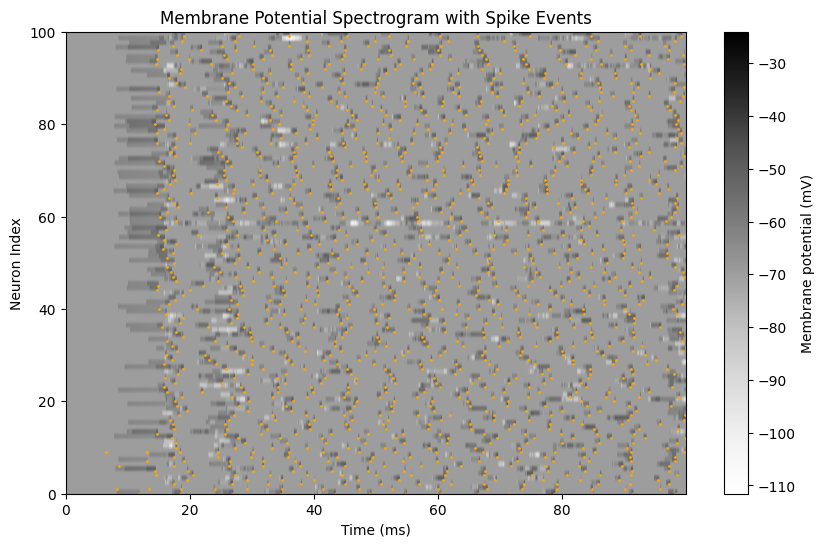

In [12]:

v_data = statemon.v / mV  # Convert to mV for easier visualization
time_data = statemon.t / ms  # Convert time to ms

plt.figure(figsize=(10, 6))
plt.imshow(v_data, aspect='auto', cmap='Greys', origin='lower', 
           extent=[time_data[0], time_data[-1], 0, num_neurons])

# Plot the spike events as dots
plt.plot(spikemon.t / ms, spikemon.i, '.k', markersize=2, label='Spikes', c='orange')

# Add labels and color bar
plt.colorbar(label='Membrane potential (mV)')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title('Membrane Potential Spectrogram with Spike Events')
plt.show()


## Comparison to NEST


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.9.0
 Built: Oct  2 2025 06:57:01

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



WARNING    /home/ericog/.local/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning:h5py is running against HDF5 1.14.6 when it was built against 1.14.2, this may cause problems
 [py.warnings]



Oct 04 16:55:59 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.001 ms.

Oct 04 16:56:00 NodeManager::prepare_nodes [Info]: 
    Preparing 112 nodes for simulation.

Oct 04 16:56:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 112
    Simulation time (ms): 100
    Number of OpenMP threads: 1
    Not using MPI

Oct 04 16:56:03 SimulationManager::run [Info]: 
    Simulation finished.


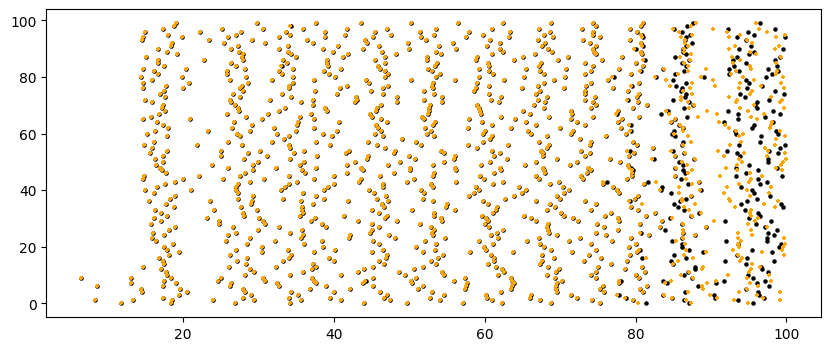

In [13]:
import nest
import numpy as np
import matplotlib.pyplot as plt

dt = 0.001
input_weight = 30

nest.ResetKernel()
nest.SetKernelStatus({"resolution": dt})  # simulation resolution in ms

# ==============================
# Create neurons
# ==============================
neurons = nest.Create("iaf_psc_delta", num_neurons, params={
    "C_m": 200.0,
    "tau_m": 20.0,
    "V_th": -50.0,
    "V_reset": -70.0,
    "E_L": -70.0,
    "t_ref": 5.0,
})

nest.SetStatus(neurons, {"V_m": -70.0})

# ==============================
# Connect neurons according to graph
# ==============================
for pre, post, weight, delay in graph:
    weight_pAms = (weight/C_m)*1000  # Convert weight to pA*ms
    delay_ms = delay*1000  # Convert delay to ms
    nest.Connect(neurons[pre], neurons[post], syn_spec={
        "weight": weight_pAms,
        "delay": delay_ms
    })

# ==============================
# Input spike generator
# ==============================
# Convert spike_storage → NEST format
spike_times_dict = {}
for t, neuron_id, _ in spike_storage:
    spike_times_dict.setdefault(neuron_id, []).append(t*1000) # s -> ms

input_generators = []
for neuron_id, times in spike_times_dict.items():
    sg = nest.Create("spike_generator", params={"spike_times": times})
    nest.Connect(sg, neurons[neuron_id], syn_spec={"weight": input_weight, "delay": dt})
    input_generators.append(sg)

# ==============================
# Recording devices
# ==============================
spikemon = nest.Create("spike_recorder")
nest.Connect(neurons, spikemon)

# Optional: membrane potential recording
statemon = nest.Create("voltmeter")
nest.Connect(statemon, neurons[0])  # record first neuron

# ==============================
# Run simulation
# ==============================
nest.Simulate(100.0)

# ==============================
# Extract spike data
# ==============================
events = nest.GetStatus(spikemon, "events")[0]
neuron_ids_nest = events["senders"]
spike_times_nest = events["times"]

# ==============================
# Plot raster
# ==============================
neuron_ids_nest_c = np.array(neuron_ids_nest) - 1  # Convert to 0-based index
plt.figure(figsize=(10,4))
plt.scatter(spike_times_nest, neuron_ids_nest_c, s=5, c='black', label="Network spikes")
plt.scatter(np.array(spike_times)*1000, neuron_ids, c='orange', s=5, marker='+')